<a href="https://colab.research.google.com/github/rahuldixit18/rahul-dixit/blob/main/Guardian_Health_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install contractions pyLDAvis category_encoders optuna joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from spacy.lang.en import English
from textblob import TextBlob
from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import Phrases, CoherenceModel, LdaModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
import plotly.express as px
import plotly.graph_objects as go
import pyLDAvis.gensim_models as gensimvis

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Reading the Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Guardian Health/Raw_Reviews.csv')
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  23486
Columns  :  6

Features :  ['Product_ID', 'Age', 'Title', 'Text_Review', 'Rating', 'Type']

Missing values :   4669

Unique values :  
 Product_ID      1206
Age               77
Title          13993
Text_Review    22634
Rating             5
Type               6
dtype: int64


##DATA CLEANING

The raw data undergoes preprocessing steps such as removing special characters, removing stop words, tokenization, lemmatization.

In [ ]:
nlp = spacy.load("en_core_web_sm")

def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

def tokenize_text(text):
    return word_tokenize(text)


def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def preprocess_text(text):
    if not isinstance(text, str):

        return ''

    text = text.lower()
    text = contractions.fix(text)
    text = remove_special_characters(text)
    words = tokenize_text(text)
    words = remove_stopwords(words)
    words = lemmatize_words(words)
    return ' '.join(words)

df['Processed_Review'] = df['Text_Review'].apply(lambda x: preprocess_text(x))
df[['Text_Review', 'Processed_Review']].head()

Text_Review  \
0  Absolutely wonderful - silky and sexy and comf...   
1  Love this dress!  it's sooo pretty.  i happene...   
2  I had such high hopes for this dress and reall...   
3  I love, love, love this jumpsuit. it's fun, fl...   
4  This shirt is very flattering to all due to th...   

                                    Processed_Review  
0        absolutely wonderful silky sexy comfortable  
1  love dress sooo pretty happened find store gla...  
2  high hope dress really wanted work initially o...  
3  love love love jumpsuit fun flirty fabulous ev...  
4  shirt flattering due adjustable front tie perf...

##EXPLORATORY ANALYSIS

In [ ]:
import plotly.express as px


ratings_count = df['Rating'].value_counts().reset_index()
ratings_count.columns = ['Rating', 'Count']
fig = px.bar(
    ratings_count,
    x='Count',
    y='Rating',
    text='Count',
    orientation='h',
    title='Distribution of Ratings',
    labels={'Count':'Number of Reviews', 'Rating':'Ratings'}, # can be customized
    height=400,
    width=800
)


fig.update_layout(
    title={'text': 'Distribution of Ratings', 'x':0.5, 'xanchor': 'center'},
    xaxis={'title':'Count'},
    yaxis={'title':'Ratings'},
    xaxis_tickformat = ',',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(x=0.1, y=0.9, traceorder='normal', font_size=12),
    font=dict(family="fantasy", size=15, color='navy')
)
fig.show()

We see that the dataset has many 5 star ratings (13,000) and just 842 1 star rating signifying a class imbalance

In [ ]:
import plotly.express as px

rating_counts = df.groupby(['Type', 'Rating']).size().reset_index(name='Count')
fig = px.bar(
    rating_counts,
    x='Type',
    y='Count',
    color='Rating',
    barmode='group',
    title='Distribution of Ratings Grouped by Type',
    labels={'Count':'Number of Reviews', 'Type':'Type of Product'},
)
fig.update_layout(
    title={'text': 'Distribution of Ratings Grouped by Type', 'x':0.5, 'xanchor': 'center'},
    xaxis={'title':'Type of Product', 'categoryorder':'total descending'},
    yaxis={'title':'Number of Reviews'},
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(title='Ratings', x=0.01, y=0.99, traceorder='normal', font_size=12),
    font=dict(family="fantasy", size=15, color='navy'),
    legend_title_font_color="navy"
)
fig.show()

Looks like the company sells many tops or the fact that tops make most of their reviews. Type "Trend" has the least

In [ ]:

fig = px.histogram(df['Age'], marginal='box',
                   labels={'value': 'Age'})

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Age of the Customers',
                  title_x=0.5, title_font=dict(size=20))
fig.show()

This Plot gives us insight that Most of the reviews are coming from people betweem ages 32 - 44

In [ ]:
df['Rating Category'] = df['Rating'].apply(lambda x: 'Above 3' if x > 3 else ('Below 3' if x < 3 else 'Exactly 3'))

df['length_of_text'] = df['Text_Review'].fillna('').apply(lambda x: len(x.split()))


fig = px.histogram(df, x='length_of_text', color='Rating Category', marginal='box',
                   labels={"length_of_text": "Length of the Text", "Rating Category": "Rating"},
                   color_discrete_map={'Above 3': 'green', 'Below 3': 'red', 'Exactly 3': 'blue'})
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))

fig.update_layout(title_text='Distribution of the Length of the Texts by Rating',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()


This plot gives us insight that positive reviews tend to be longer and show more variability in length, while negative reviews are generally shorter and more consistent in size.


In [ ]:
avg_rating = df.groupby('Type')['Rating'].mean().sort_values(ascending=False)
avg_rating = avg_rating.round(2)
avg_rating = avg_rating.reset_index()
fig = px.bar(avg_rating,
             x='Type',
             y='Rating',
             title='Average Ratings by Product Type',
             labels={'Rating': 'Average Rating'},
             color='Rating',  # Color the bars by their height value
             text='Rating')   # Display the rating values on the bars

fig.update_layout(
    xaxis_title='Type',
    yaxis_title='Average Rating',
    xaxis={'categoryorder':'total descending'},
    coloraxis_colorbar=dict(title='Rating Scale')
)
fig.update_layout(yaxis_range=[3.5,4.5])
fig.show()

The most negative rating is within the "Trend" Product category. This could also be because of the fact that the sample size collected for Trend is really small(~ 120 data points)

In [ ]:

age_bins = pd.qcut(df['Age'], q=5).rename('age_bins')
df = pd.concat([df, age_bins], axis=1)
df_age=df.groupby('age_bins').agg({'Rating': 'mean', 'Processed_Review': 'count'}).reset_index().rename(columns={'Rating': 'Average_Rating', 'Processed_Review': 'count_reviews', 'age_bins': 'Age_Groups'})
df_age
fig = go.Figure()

fig.add_trace(go.Bar(x=df_age['Age_Groups'].astype(str), y=df_age['Average_Rating'], name='Average Rating', yaxis='y1',width=0.5))
fig.add_trace(go.Scatter(x=df_age['Age_Groups'].astype(str), y=df_age['count_reviews'], name='Count of Reviews', yaxis='y2', ))

fig.update_layout(
    yaxis2=dict(
        title='Count of Reviews',
        titlefont=dict(
            color='blue'
        ),
        tickfont=dict(
            color='orange'
        ),
        overlaying='y1',
        side='right'
    )
)

fig.update_layout(
    title='Average Rating vs. Count of Reviews by Age Group',
    xaxis=dict(
        title='Age Group'
    ),
    yaxis=dict(
        title='Average Rating'
    ),
    legend=dict(
        x=0.8,
        y=1.0
    )
)
fig.update_layout(yaxis_range=[3.5,4.4])
# fig.update_traces(width=1)
fig.show()

This plot shows us that the average rating is pretty similar across all age groups with 54-99 being the highest. The number of reviews given by 18-39 are pretty high with a sharp dip to the age group 39-45.

In [ ]:
df_age_type = df.groupby(['Type','age_bins'])['Rating'].mean().sort_values(ascending=False).reset_index()
df_age_type['age_bins'] = df_age_type['age_bins'].astype(str)

fig = go.Figure()

# Add a bar trace for each category
for category in df_age_type['Type'].unique():
    df_category = df_age_type[df_age_type['Type'] == category]
    fig.add_trace(go.Bar(
        x=df_category['age_bins'],
        y=df_category['Rating'],
        name=category
    ))

fig.update_layout(
    title='Ratings by Category and Age Bin',
    xaxis=dict(
        title='Age Bin'
    ),
    yaxis=dict(
        title='Rating'
    ),
    legend=dict(
        x=1,
        y=1
    )
)
fig.update_layout(yaxis_range=[3.5,4.4])
fig.show()

This plot gives us some key observations :

1. Age Group 39-45 are more critical towards their jackets than the rest
2. The company's flagship product category is likely intimate - since it has satisfied all age groups a little better than the rest
3. Tops are popular and highly rated among the 54+ age group
4. Not much variance in Average rating for categories other than trend - but also there are just 119 data points for this category. The new trends that they are launching should cater to the 18-33 group since 33-39 have a liking towards the company's "Trend" product category, which means the company can capture the age 18-39 market segment.

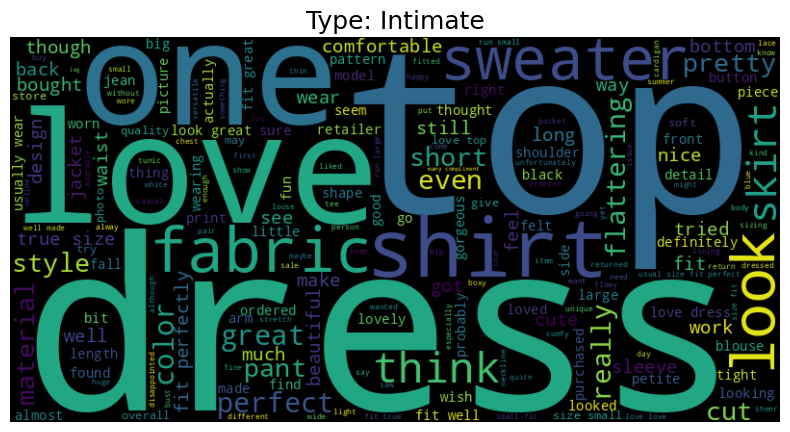

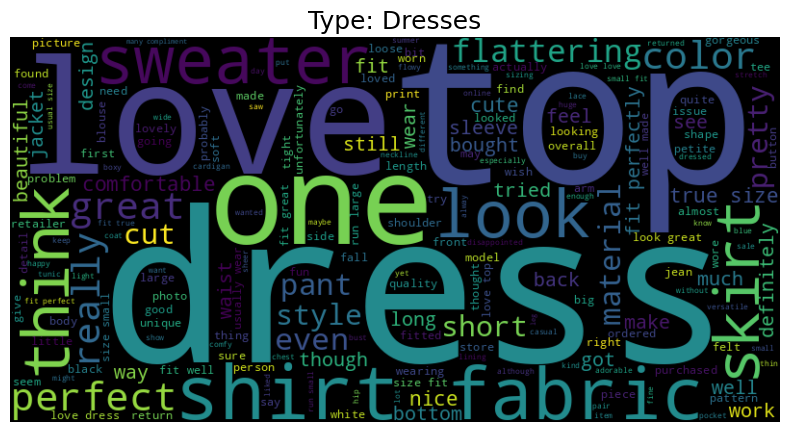

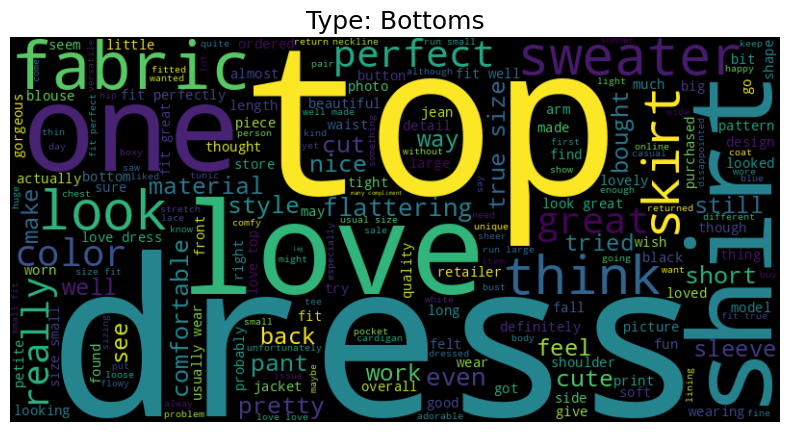

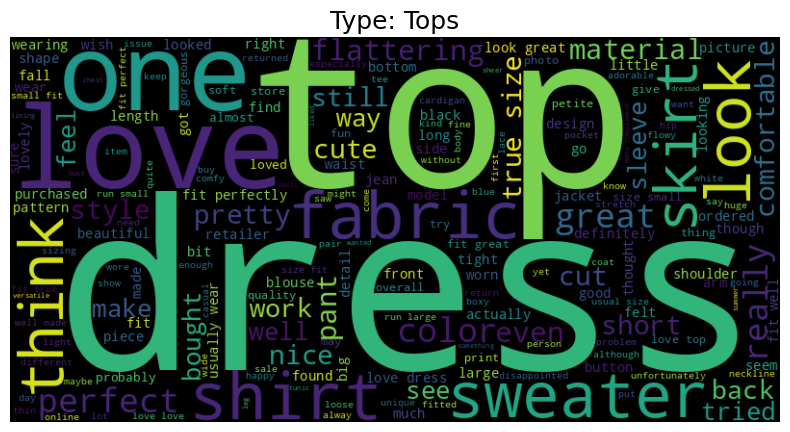

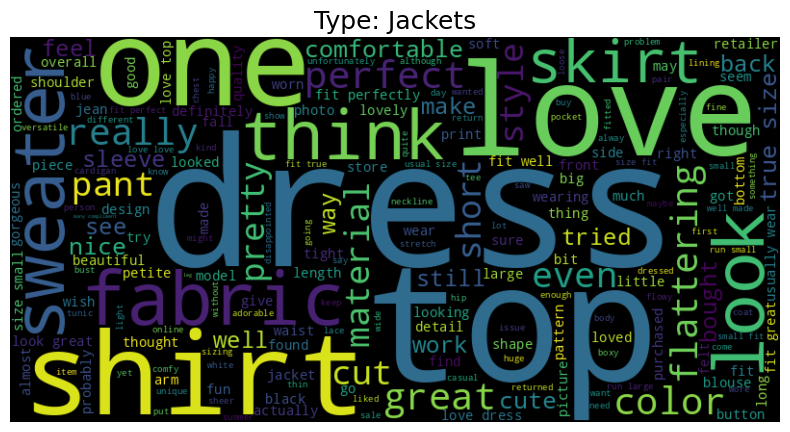

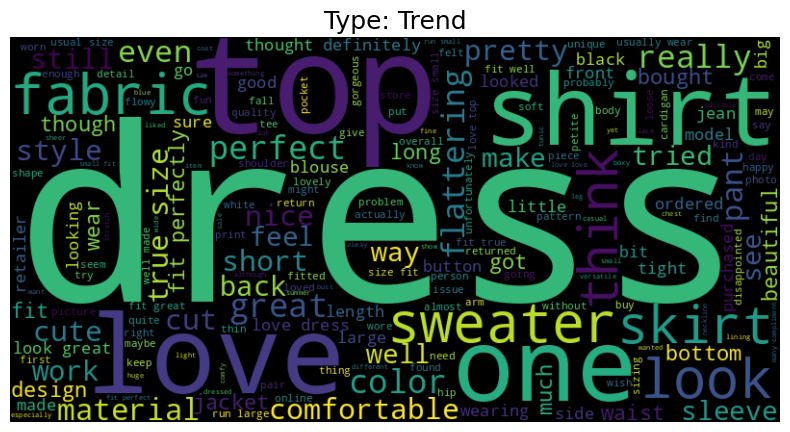

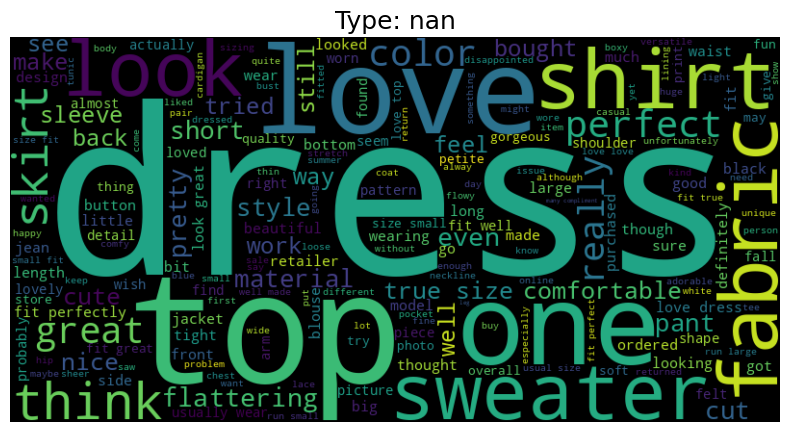

In [ ]:
types = df['Type'].unique()
for t in types:
  if t!='nan':
      text = ' '.join(review for review in df['Processed_Review'] if review)
      wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
      plt.figure(figsize=(10, 5))
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.title(f"Type: {t}", fontsize=18)
      plt.axis('off')
      plt.show()
      print("\n" * 2)

DRESS IS SHOWING UP TOO MUCH SO I'M GOING TO REMOVE IT IN ORDER TO EXAMINE OTHER WORDS

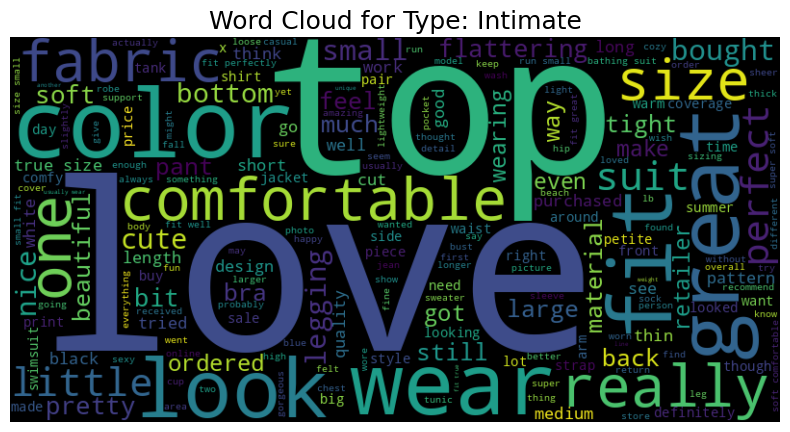

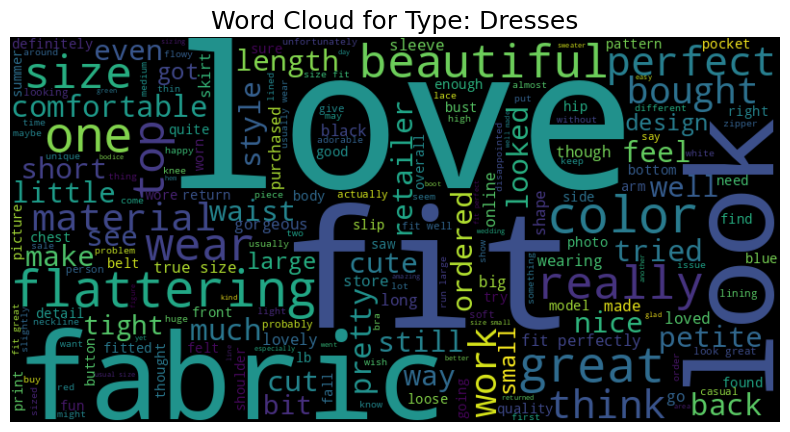

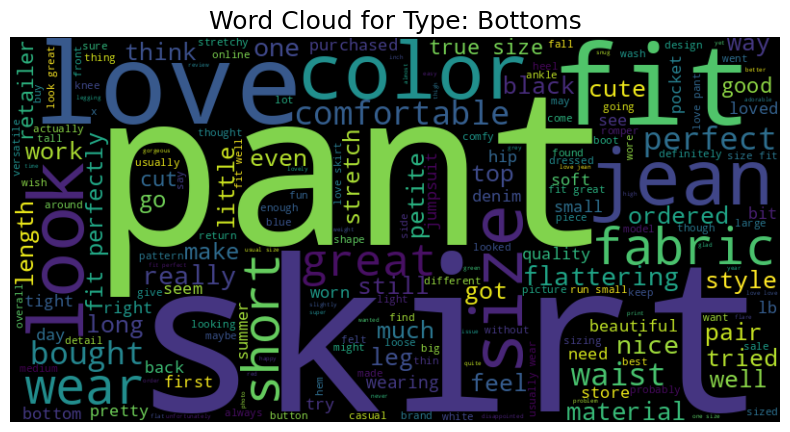

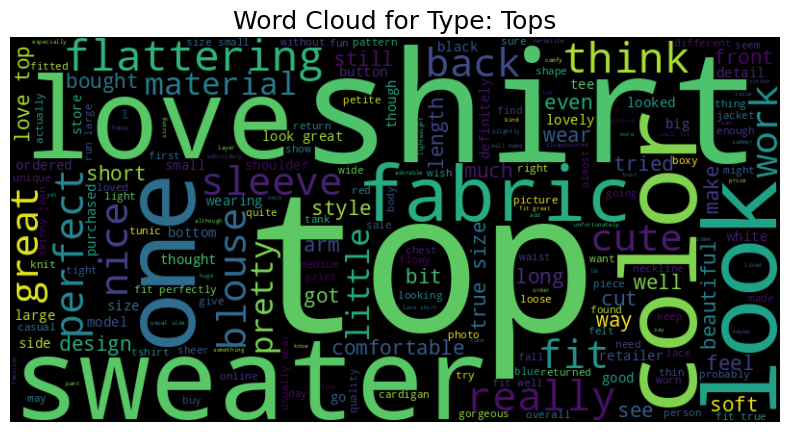

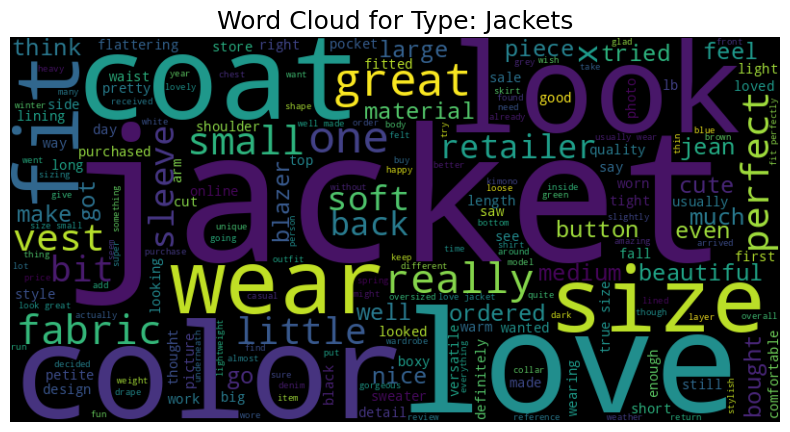

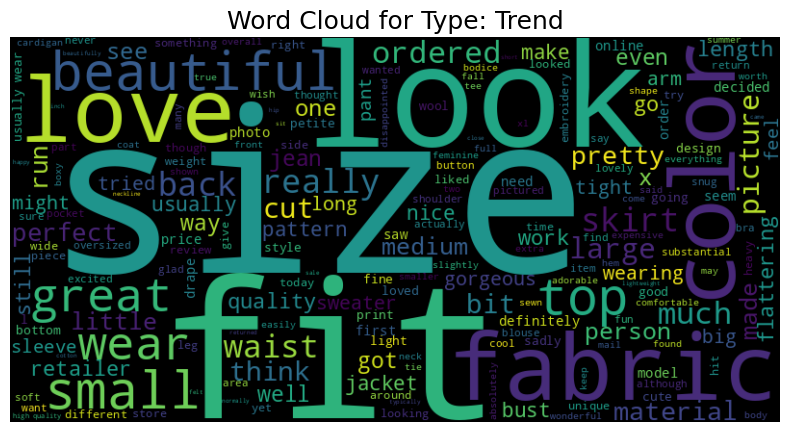

In [ ]:
stopwords = set(WordCloud().stopwords)
stopwords.update(['dress']) #removing dress here
types = df['Type'].dropna().unique()
for t in types:
  text = ' '.join(review for review in df[df['Type'] == t]['Processed_Review'] if review)
  wordcloud = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords).generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f"Word Cloud for Type: {t}", fontsize=18)
  plt.axis('off')
  plt.show()
  print("\n" * 2)

DRILLING DOWN BY TYPE AND FOR NEGATIVE AND POSITIVE SENTIMENT

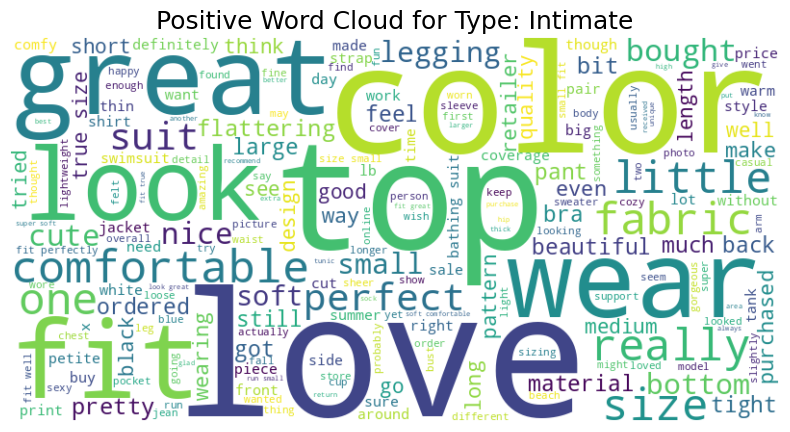

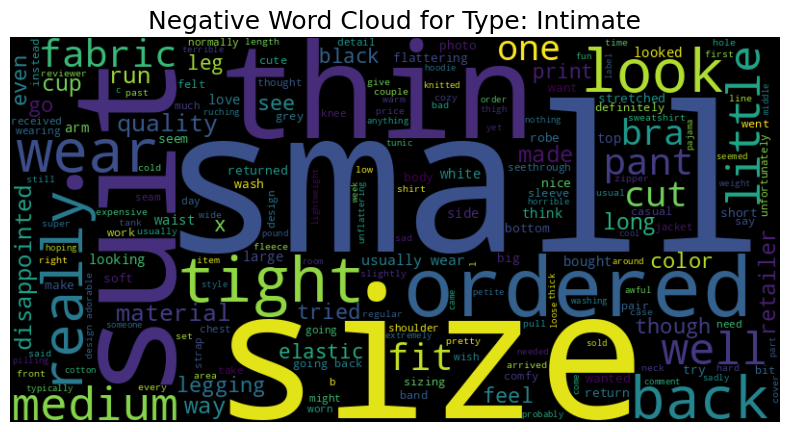

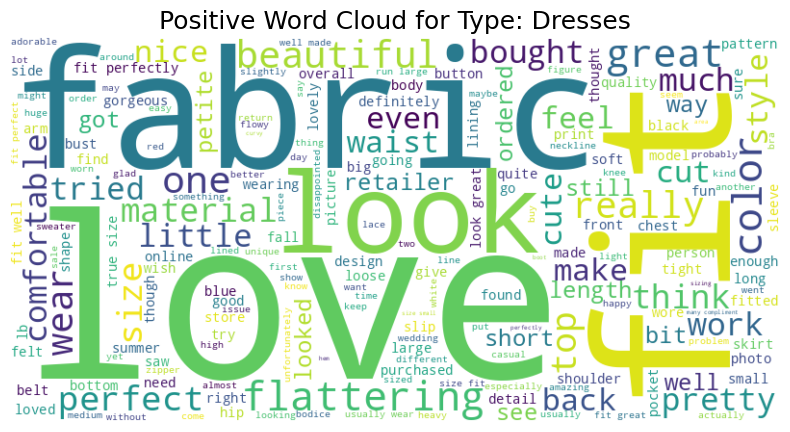

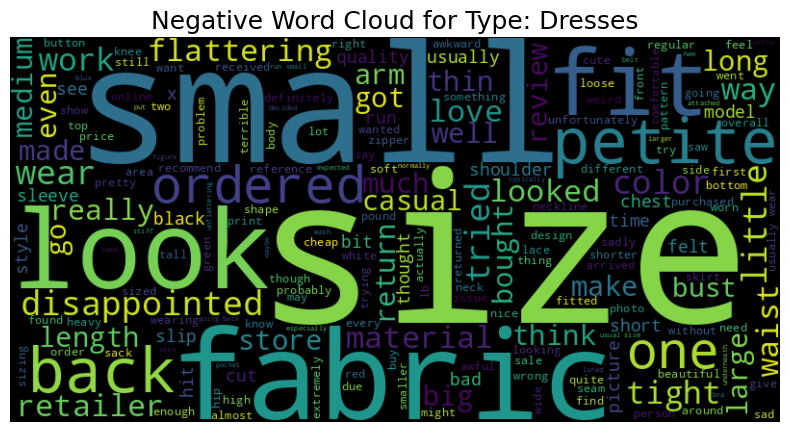

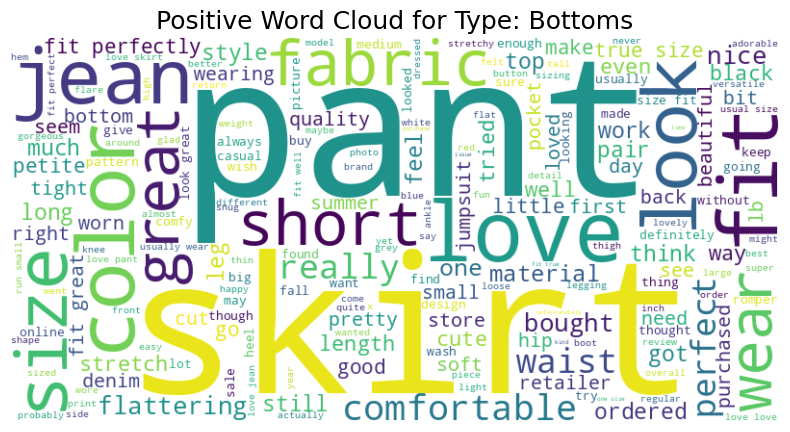

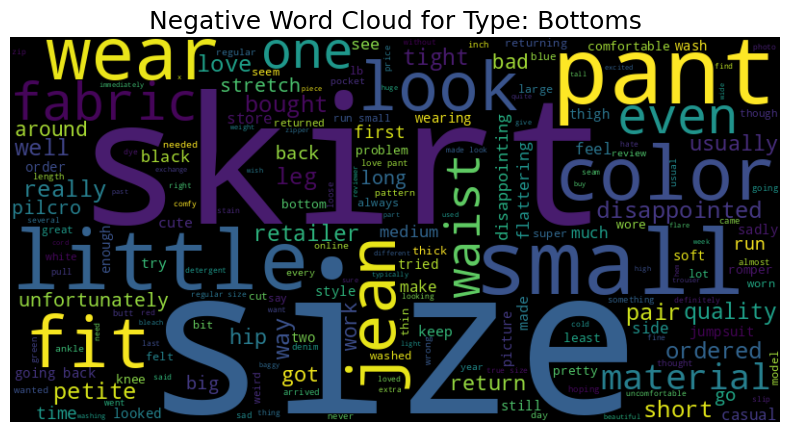

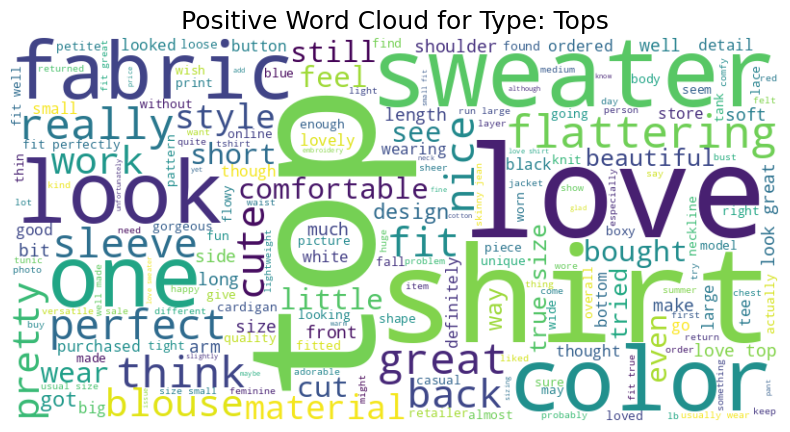

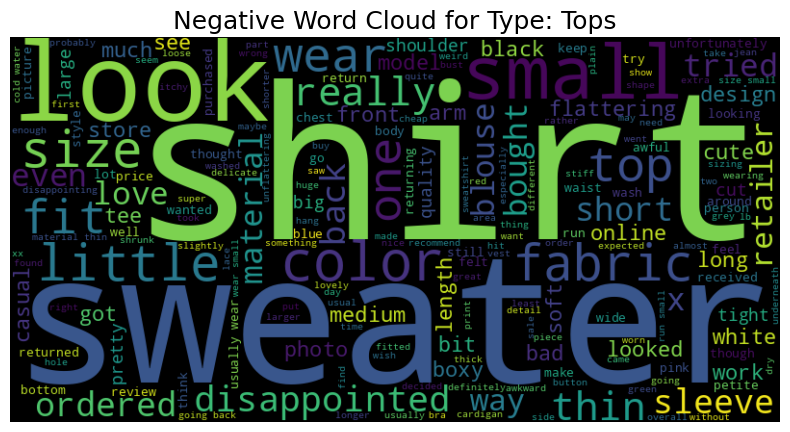

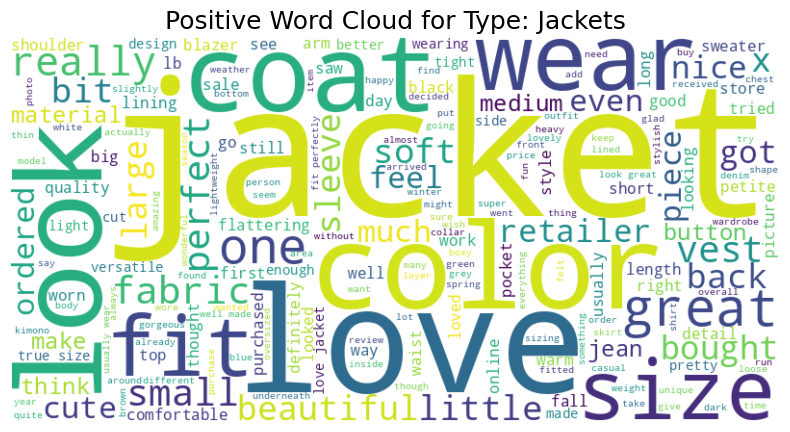

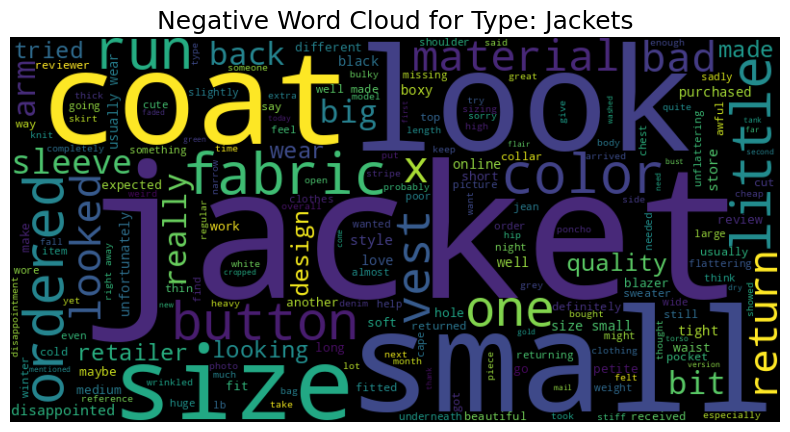

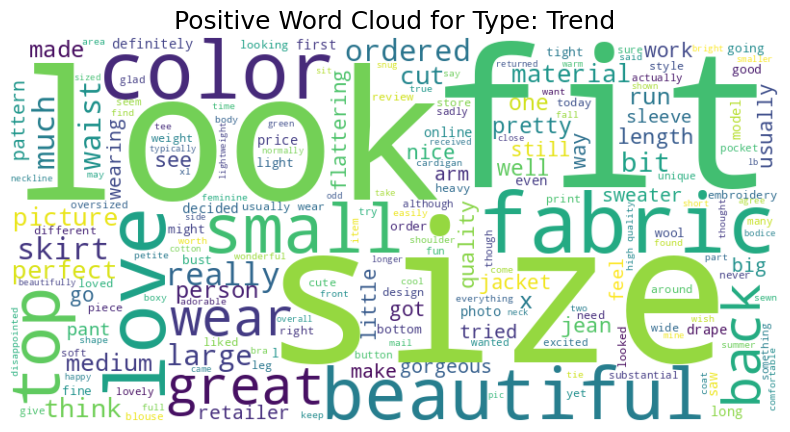

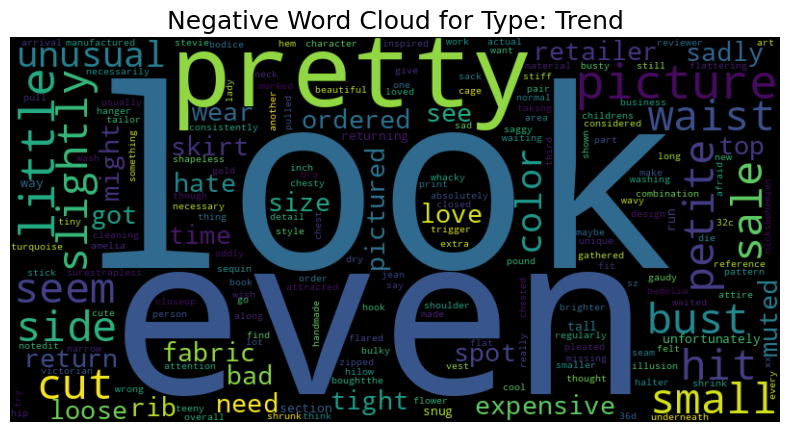




Product Type: Intimate
Top 10 Positive Words: [('fit', 641), ('love', 605), ('size', 574), ('wear', 460), ('great', 431), ('top', 407), ('color', 391), ('small', 357), ('soft', 339), ('look', 329)]
Top 10 Negative Words: [('small', 52), ('size', 41), ('wear', 29), ('back', 25), ('suit', 24), ('thin', 24), ('ordered', 22), ('look', 20), ('tight', 18), ('really', 18)]


Product Type: Dresses
Top 10 Positive Words: [('fit', 2961), ('size', 2648), ('love', 2268), ('look', 1719), ('wear', 1698), ('color', 1594), ('fabric', 1552), ('great', 1437), ('flattering', 1176), ('perfect', 1105)]
Top 10 Negative Words: [('size', 151), ('small', 120), ('fabric', 99), ('look', 96), ('little', 72), ('back', 72), ('wear', 71), ('ordered', 66), ('fit', 62), ('petite', 62)]


Product Type: Bottoms
Top 10 Positive Words: [('fit', 2053), ('size', 1787), ('love', 1522), ('pant', 1299), ('skirt', 1286), ('great', 1160), ('jean', 1084), ('color', 1049), ('wear', 1029), ('look', 996)]
Top 10 Negative Words: [

In [ ]:
stopwords = set(WordCloud().stopwords)
stopwords.update(['dress'])

types = df['Type'].dropna().unique()

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity
top_words = {}
for t in types:

    df_type = df[df['Type'] == t].dropna(subset=['Processed_Review'])
    df_type['Sentiment'] = df_type['Processed_Review'].apply(get_sentiment)
    positive_reviews = ' '.join(review for review in df_type[df_type['Sentiment'] > 0]['Processed_Review'])
    negative_reviews = ' '.join(review for review in df_type[df_type['Sentiment'] < 0]['Processed_Review'])
    positive_words = [word for word in positive_reviews.split() if word.lower() not in stopwords]
    positive_freq = Counter(positive_words)
    top_positive = positive_freq.most_common(10)

    # Getting word frequencies for negative sentiment
    negative_words = [word for word in negative_reviews.split() if word.lower() not in stopwords]
    negative_freq = Counter(negative_words)
    top_negative = negative_freq.most_common(10)
    top_words[t] = {'positive': top_positive, 'negative': top_negative}

    if positive_reviews:
        wordcloud_pos = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(positive_reviews)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_pos, interpolation='bilinear')
        plt.title(f"Positive Word Cloud for Type: {t}", fontsize=18)
        plt.axis('off')
        plt.show()

    if negative_reviews:
        wordcloud_neg = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords).generate(negative_reviews)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_neg, interpolation='bilinear')
        plt.title(f"Negative Word Cloud for Type: {t}", fontsize=18)
        plt.axis('off')
        plt.show()

    print("\n" * 2)

for product_type, sentiments in top_words.items():
    print(f"Product Type: {product_type}")
    print("Top 10 Positive Words:", sentiments['positive'])
    print("Top 10 Negative Words:", sentiments['negative'])
    print("\n")

**Intimate**: Although customers frequently highlight "fit" and "love" in a positive light, "small" and "size" are frequently mentioned in both positive and negative contexts, which may point to problems with size.


**Dresses**: In good reviews, the words "fit" and "love" are often highlighted, while the terms "size" and "fabric" appear in both positive and negative reviews, indicating that these are important aspects of the customer experience.

**Bottoms**: "Size" and "fit" predominately appear in good discussions, with "pant" and "skirt" also making an appearance. Conversely, negative mentions also highlight sizing difficulties.

**Tops**: The most positive term is "top," which is followed by "love" and "fit." Negative words include "small" and "shirt," which allude to problems with fit.

**Jackets**: "Love" and "jacket" are often mentioned in positive reviews; yet, "small" appears in bad reviews, suggesting that there may be sizing issues.

**Trend:** "Size" and "fit" are highlights of the positive; negatives are less common and less diversified.



Across all categories, "fit", "size", and "love" are recurrent themes in positive reviews, while "small" and "size" often appear in negative ones, indicating that while customers appreciate the style and fit, incorrect sizing is a common issue.

##LDA TOPIC MODELING

I ran Latent Dirichlet Allocation on our product reviews because it's like a detective tool that sorts through all the chatter to find out what's really being talked about. It digs into the piles of feedback we get and pulls out the main themes, so we know what's hitting home with our customers and what's not. This isn't just about counting words; it's about seeing the big-picture trends in what our buyers are saying, which can totally steer how we tweak our products and the way we talk about them. Plus, it's a smart move for staying ahead because it tells us exactly where we're nailing it and where we need to up our game

In [ ]:
token_text = [review.split() for review in df['Processed_Review']]
dictionary = corpora.Dictionary(token_text)
dictionary.filter_extremes(no_below=50, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in token_text]

print(f'Number of unique tokens: {len(dictionary)}')

Number of unique tokens: 1334


In [ ]:
tokenized_reviews = [review.split() for review in df['Processed_Review']]

review_dictionary = corpora.Dictionary(tokenized_reviews)
review_dictionary.filter_extremes(no_below=50, no_above=0.5)

review_corpus = [review_dictionary.doc2bow(text) for text in tokenized_reviews]
print(f'Total unique tokens: {len(review_dictionary)}')

Total unique tokens: 1334


Optimizing hyperparameters of the LDA using OPTUNA

Optuna is a hyperparameter optimization framework and is being adopted widely. Its my personal favourite! Other contenders include Hyperopt, Asha

In [ ]:
import optuna
def objective(trial):
    num_topics = trial.suggest_int('num_topics', 1, 10)
    chunksize = trial.suggest_categorical('chunksize', [100, 200, 300, 400])
    passes = trial.suggest_int('passes', 5, 20)
    num_iterations = trial.suggest_int('passes', 20, 100)
    alpha = trial.suggest_categorical('alpha', ['auto', 'symmetric', 'asymmetric'])

    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics = num_topics,
                         iterations= num_iterations,
                         random_state=42,
                         chunksize=chunksize,
                         passes=passes,
                         alpha=alpha,
                         per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    return coherence_score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

print("Best parameters:", study.best_params)
print("Best coherence score: {:.2f}".format(study.best_value))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2024-04-22 13:22:45,913] A new study created in memory with name: no-name-0d324c99-b55d-438e-8943-ff4430bfc651
[I 2024-04-22 13:24:03,349] Trial 0 finished with value: 0.47456481372065723 and parameters: {'num_topics': 6, 'chunksize': 400, 'passes': 19, 'alpha': 'auto'}. Best is trial 0 with value: 0.47456481372065723.
[I 2024-04-22 13:24:17,414] Trial 1 finished with value: 0.36132709336795993 and parameters: {'num_topics': 1, 'chunksize': 100, 'passes': 6, 'alpha': 'symmetric'}. Best is trial 0 with value: 0.47456481372065723.
[I 2024-04-22 13:25:58,953] Trial 2 finished with value: 0.4808391229312491 and parameters: {'num_topics': 

Best parameters: {'num_topics': 9, 'chunksize': 400, 'passes': 11, 'alpha': 'asymmetric'}
Best coherence score: 0.50


In [ ]:
#pip install joblib

In [ ]:
import joblib

In [ ]:
#joblib.dump(study, '/content/drive/My Drive/Guardian Health/optuna_study.pkl')

In [ ]:

study = joblib.load('/content/drive/My Drive/Guardian Health/optuna_study.pkl')
print(study.best_params)

{'num_topics': 9, 'chunksize': 400, 'passes': 11, 'alpha': 'asymmetric'}


In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim import corpora

def compute_coherence_and_assign_topics(dictionary, corpus, texts, coherence_type, study, dataframe):
    coherence_scores = []

    model = LdaModel(corpus=corpus, id2word=dictionary,
                     chunksize=study.best_params['chunksize'],
                     alpha=study.best_params['alpha'],
                     iterations=100,
                     num_topics=study.best_params['num_topics'],
                     passes=study.best_params['passes'],
                     random_state=42)

    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
    score = coherence_model.get_coherence()
    coherence_scores.append(score)
    print(f'Coherence Score: {score:.4f}')

    top_topics = model.print_topics(num_words=10)
    for topic_no, topic in top_topics:
        words = ', '.join(word for word, _ in model.show_topic(topic_no, topn=10))
        print(f"\nTopic {topic_no}")
        print(topic)
        print(f"[{words}]")
    topic_distribution = [model.get_document_topics(bow) for bow in corpus]
    dominant_topics = []
    for doc_topics in topic_distribution:
        if doc_topics:
            dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
            dominant_topics.append(dominant_topic)
        else:
            dominant_topics.append(None)
    dataframe['Dominant_Topic'] = dominant_topics

    return model, coherence_scores, dataframe
lda_model, scores,df_topic  =  compute_coherence_and_assign_topics(review_dictionary, review_corpus, tokenized_reviews, 'c_v', study,df.copy())

Coherence Score: 0.4344

Topic 0
0.031*"like" + 0.025*"look" + 0.022*"would" + 0.019*"fit" + 0.015*"fabric" + 0.014*"petite" + 0.014*"top" + 0.014*"really" + 0.013*"waist" + 0.013*"color"
[like, look, would, fit, fabric, petite, top, really, waist, color]

Topic 1
0.029*"love" + 0.028*"color" + 0.021*"sweater" + 0.017*"wear" + 0.016*"great" + 0.015*"soft" + 0.014*"look" + 0.014*"like" + 0.013*"top" + 0.011*"fit"
[love, color, sweater, wear, great, soft, look, like, top, fit]

Topic 2
0.105*"size" + 0.058*"small" + 0.038*"large" + 0.036*"run" + 0.035*"fit" + 0.029*"medium" + 0.025*"ordered" + 0.025*"usually" + 0.023*"wear" + 0.019*"top"
[size, small, large, run, fit, medium, ordered, usually, wear, top]

Topic 3
0.209*"dress" + 0.024*"fit" + 0.019*"4" + 0.019*"perfect" + 0.018*"flattering" + 0.015*"beautiful" + 0.012*"lb" + 0.011*"love" + 0.010*"perfectly" + 0.009*"slip"
[dress, fit, 4, perfect, flattering, beautiful, lb, love, perfectly, slip]

Topic 4
0.047*"store" + 0.030*"online" + 

In [ ]:
#df_topic.to_csv('/content/drive/MyDrive/Guardian Health/df_topic.csv', index=False)

In [ ]:
df_topic = pd.read_csv('/content/drive/MyDrive/Guardian Health/df_topic.csv')

In [ ]:
from gensim.models import LdaModel
lda_model = LdaModel.load('/content/drive/MyDrive/Guardian Health/lda_model.gensim')
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


vis_data = gensimvis.prepare(lda_model, review_corpus, review_dictionary)
pyLDAvis.display(vis_data)

(0, '0.030*"like" + 0.024*"look" + 0.022*"would" + 0.021*"fit" + 0.015*"fabric" + 0.014*"petite" + 0.014*"top" + 0.014*"really" + 0.012*"waist" + 0.012*"color"')
(1, '0.028*"love" + 0.028*"color" + 0.020*"sweater" + 0.017*"wear" + 0.016*"great" + 0.015*"soft" + 0.014*"look" + 0.014*"like" + 0.013*"top" + 0.012*"fit"')
(2, '0.107*"size" + 0.056*"small" + 0.041*"large" + 0.039*"run" + 0.029*"fit" + 0.028*"medium" + 0.024*"ordered" + 0.024*"wear" + 0.023*"usually" + 0.019*"top"')
(3, '0.213*"dress" + 0.025*"fit" + 0.021*"4" + 0.019*"perfect" + 0.019*"flattering" + 0.015*"beautiful" + 0.011*"love" + 0.011*"perfectly" + 0.011*"lb" + 0.010*"wear"')
(4, '0.047*"store" + 0.031*"online" + 0.028*"sale" + 0.028*"tried" + 0.025*"saw" + 0.025*"price" + 0.024*"one" + 0.020*"would" + 0.018*"try" + 0.017*"loved"')
(5, '0.068*"jean" + 0.063*"pant" + 0.042*"pair" + 0.038*"legging" + 0.024*"wear" + 0.023*"skinny" + 0.023*"black" + 0.021*"wash" + 0.019*"bought" + 0.016*"denim"')
(6, '0.237*"shirt" + 0.050

LDA INTERPRETATION



**Topic 0: Fit and Clothes**

The look and fit of clothing appear to be the main topics of discussion here. "Like", "look", "would", "fit", "fabric", "petite", "top", "really", "waist", and "color" are among the keywords. It implies that reviews or conversations regarding how well clothes fits and appears on various body shapes are included in the text data.


**Topic 1: Love and Joyful Emotions**

"Love", "color", "sweater", "wear", "great", "soft", "look", "like", "top", and "fit" are the primary keywords associated with this topic, which revolves around good emotions and feelings. It signifies that the textual data includes reviews or conversations that highlight the advantages of clothes, such as how much people adore particular pieces or how they make the wearer feel.


**Topic 2: Dimensions and Fit**

This subject relates to garment fit and size. The terms "size", "small", "large", "run", "fit", "medium", "ordered", "wear", "usually", and "top" are among them. It implies that reviews or conversations regarding how well clothes fits various body types and sizes are included in the text data.






**Topic 3: Fit and Style in Dresses**
This discussion is about dresses and finding the ideal fit. The following keywords are included: "dress", "fit", "4", "perfect", "flattering", "beautiful", "love", "perfectly", "lb", and "wear". It suggests that evaluations or conversations regarding dresses, highlighting their exquisite appearance and ideal fit, are present in the text data.

**Topic 4: Internet Sales and Shopping**

This subject is sales and purchasing on the internet. "Store", "online", "sale", "tried", "saw", "price", "one", "would", "try", and "loved" are among the keywords. It implies that the textual data includes opinions or conversations regarding internet shopping, including testing out deals and the whole purchasing process.


**Topic 5: Leggings and Jeans**

The focus of this discussion is on leggings and jeans. "Jean", "pant", "pair", "legging", "wear", "skinny", "black", "wash", "bought", and "denim" are among the keywords. It suggests that the textual data includes comments or reviews of jeans and leggings with an emphasis on style and wearability.

**Topic 6: Clothes and Accessories**

The topic of discussion is clothing and shirts. The terms "tad", "romper", "yellow", "home", "beading", "upper", "hole", "arm", "wardrobe", and "shirt" are among them. It implies that the textual data includes opinions or conversations regarding shirts, including their function in a person's wardrobe and sense of style.


**Topic 7: Ease and Joyful Sensations**

The focus of this discussion is comfort and good vibes. "Great", "love", "super", "comfortable", "perfect", "fit", "cute", "jean", "soft", and "wear" are among the keywords. It suggests that the textual data includes opinions or conversations regarding the advantages and comfort of wearing particular clothes.

**Subject 8: Upper and Lower Apparel**
This article is about underwear and tops. "Top", "back", "bra", "blouse", "front", "sheer", "fabric", "neck", "low", and "tank" are among the keywords. It implies that the textual material includes conversations or reviews of tops and underwear, with an emphasis on fit and design.

In [ ]:
lda_model.save('/content/drive/My Drive/Guardian Health/lda_model.gensim')

#LLM TO PREDICT CUSTOMER SATISFACTION

I tried multiple LLM's to test out whether the prediction was somehow in line with the rating provided or the context of the text review. The LLM's I tried were

1. Distilled Bert -> generated longer summaries and not accurate
2. Roberta model -> not significant summary's
3. Pegasus X-sum ->for summarizing the empty title's and creating a comparison between predicted summary vs title, the problem was that it was too large (Exhausted my compute on collab) and my computer was taking hours to process it
4. bert base uncased sentiment - > gives output as stars which is like Customer satisfaction

I chose Bert base uncases sentiment since it gave the most apt satisfaction scores



In [ ]:
import pandas as pd
from transformers import pipeline

classifier_rating = pipeline("text-classification", model='nlptown/bert-base-multilingual-uncased-sentiment', return_all_scores=True)
def classify_and_extract_scores_rating(token):
    try:
        text = ' '.join(token)
        text_to_classify = text
        predictions = classifier_rating(text_to_classify)
        scores = {pred['label']: pred['score'] for pred in predictions[0]}
        return pd.Series(scores)
    except Exception as e:
        print("Error processing text:", e)
        return pd.Series([float('nan')] * 5, index=['1', '2', '3', '4', '5'])
df_uncased = df.copy()
rating_columns = df_uncased['Processed_Review'].apply(classify_and_extract_scores_rating)
df_sentiment = pd.concat([df_uncased, rating_columns], axis=1)

In [ ]:
#df_sentiment.to_csv('/content/drive/MyDrive/Guardian Health/df_new_sentiment.csv', index=False)

In [ ]:
df_sentiment = pd.read_csv('/content/drive/MyDrive/Guardian Health/df_new_sentiment.csv')

In [ ]:
rating_map = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}
df_sentiment['predicted_satisfaction'] = df_sentiment['highest_rating'].map(rating_map)

In [ ]:
import plotly.graph_objects as go
import pandas as pd

actual_counts = df_sentiment['Rating'].value_counts().sort_index()
predicted_counts = df_sentiment['predicted_satisfaction'].value_counts().sort_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=actual_counts.index,
    y=actual_counts.values,
    name='Actual Ratings',
    marker_color='rgb(55, 83, 109)'
))

fig.add_trace(go.Bar(
    x=predicted_counts.index,
    y=predicted_counts.values,
    name='Predicted Ratings',
    marker_color='rgb(26, 118, 255)'
))

fig.update_layout(
    title='Actual Ratings vs Predicted Ratings',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Frequency',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)
fig.show()


Comparison between frequency of the LLM's star rating vs Input Rating. We can see that its pretty similar just that 5 star model predictions are a little more critical than actual ratings.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
df_sentiment['Final_Sentiment'] = df_sentiment['predicted_satisfaction'].apply(
    lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral')
)
df_ngram = df_sentiment[df_sentiment['Final_Sentiment'] != 'neutral'].dropna(subset = 'Processed_Review')

ngrams_dict = dict()
for i in sorted(df_ngram['Final_Sentiment'].unique(), reverse=True):
    X = df_ngram[df_ngram['Final_Sentiment'] == i]['Processed_Review']
    for n in range(1, 4):
        vectorizer = CountVectorizer(max_features=10, ngram_range=(n, n))
        DTM = vectorizer.fit_transform(X)
        frequencies = sum(DTM).toarray()[0]
        ngrams = pd.DataFrame(frequencies, index=vectorizer.get_feature_names_out(), columns=['Frequency'])
        ngrams.sort_values('Frequency', ascending=False, inplace=True)
        ngrams = ngrams.reset_index().rename(columns={'index': 'Term'})
        ngrams['ngram'] = n
        ngrams['recommend'] = i
        ngrams_dict[str(i) + '_' + str(n)] = ngrams

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f"Sentiment: {key.split('_')[0]} - Ngram: {key.split('_')[1]}" for key in ngrams_dict.keys()]
)

row_val = 1
col_val = 1

for i, (key, to_plot) in enumerate(ngrams_dict.items()):
    to_plot.sort_values('Frequency', inplace=True)
    color = 'red' if 'negative' in key else 'green'
    fig.add_trace(
        go.Bar(
            x=to_plot['Frequency'],
            y=to_plot['Term'],
            orientation='h',
            marker_color=color,
            name=key
        ),
        row=row_val,
        col=col_val
    )
    col_val += 1
    if col_val > 3:
        col_val = 1
        row_val += 1

fig.update_layout(
    title_text='N grams - Uni-Gram,Bi-Gram,Tri-Gram by sentiment',
    height=1200,
    showlegend=False
)

fig.update_xaxes(title_text="Frequency")
fig.update_yaxes(title_text="Ngram")
fig.show()

# UNIGRAM, BIGRAM & TRIGRAM GRAM ANALYSIS


Common Terms found in positive sentiment reviews :

1.   Fit True Size
2.   Fit Perfectly
3.   Recieved Many compliments

Common Terms found in negative sentiment reviews :
1.   Sad going back - either to return / shop
2.   make look like ( makes me think that the product was trying to copy another product and it went wrong )
3. ordered usual size ( makes me think people ordered a usual size but ended up getting something that's too big/small)
4. There is a 1 gram which mentions fabric - I think that some of the products don't have good fabric



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

ngrams_by_type_sentiment = {}
product_types = df_sentiment['Type'].unique()
for product_type in product_types:
    for sentiment in ['positive', 'negative']:
        filtered_reviews = df_sentiment[(df_sentiment['Type'] == product_type) & (df_sentiment['Final_Sentiment'] == sentiment)]['Processed_Review'].dropna()
        if filtered_reviews.empty:
            print(f"No reviews for type {product_type} with sentiment {sentiment}, hence skipping")
            continue

        for n in [2, 3]:
            try:
                vectorizer = CountVectorizer(max_features=5, ngram_range=(n, n), stop_words='english')
                DTM = vectorizer.fit_transform(filtered_reviews)
                frequencies = sum(DTM).toarray()[0]
                terms = vectorizer.get_feature_names_out()
                ngrams_df = pd.DataFrame({'Term': terms, 'Frequency': frequencies})
                ngrams_df.sort_values(by='Frequency', ascending=False, inplace=True)
                key = f'{product_type}_{sentiment}_{n}-gram'
                ngrams_by_type_sentiment[key] = ngrams_df
            except ValueError as e:
                print(f"Error processing type {product_type} with sentiment {sentiment} for {n}-grams: {e}")

No reviews for type nan with sentiment positive, hence skipping
No reviews for type nan with sentiment negative, hence skipping


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

num_types = len(product_types)
fig = make_subplots(rows=num_types * 2, cols=2, subplot_titles=[key for key in ngrams_by_type_sentiment.keys()])

row_val = 1
for i, (key, to_plot) in enumerate(ngrams_by_type_sentiment.items()):
    col_val = 1 if '2-gram' in key else 2

    fig.add_trace(
        go.Bar(
            x=to_plot['Frequency'],
            y=to_plot['Term'],
            orientation='h',
            name=key
        ),
        row=row_val,
        col=col_val
    )

    if col_val == 2:
        row_val += 1

fig.update_layout(
    title_text='Top 2-grams and 3-grams in Reviews by Product Type and Sentiment',
    height=300 * num_types * 2,
    showlegend=False
)
fig.update_xaxes(title_text="Frequency")
fig.update_yaxes(title_text="Ngram")
fig.show()

# BI-GRAM TRI-GRAM ANALYSIS BY PRODUCT TYPE

* **Fit and Size**: Fitting and sizing are common themes across all product types,
often featuring prominently in both positive and negative reviews. This indicates that when the fit is right, it's a strong positive, but when expectations around fit and size are not met, it becomes a primary source of dissatisfaction

* **Mismatch in expectation**: Many negative n-grams suggest a discrepancy between what customers expected and what they perceived they received, particularly in terms of appearance and fit.

* **Material and Design**: Some negative sentiments may be related to material ("fabric," "quality") and design ("cut," "style"), also post wash problems but this is less prominent than issues related to size and fit.


**Recommendations for the Business**:

* **Quality Control in Sizing**: There seems to be a need for more consistent sizing to reduce the negative experiences related to fit.
* **Clearer Product Descriptions**: Providing clearer and more detailed product descriptions might help manage customer expectations, especially with regards to product appearance and sizing.
* **Enhance Customer Feedback Loop**: Utilizing this feedback to improve product design, descriptions, and sizing guides could lead to higher customer satisfaction.

#SATISFACTION / SENTIMENT PREDICTION BASED ON TEXT -  ML + NLP


**THE GOAL OF THE MODEL WILL BE REDUCE THE MISCLASSIFICATION OF NEGATIVE SENTIMENT REVIEWS AS POSITIVE - > WE WILL FOCUS ON MAXIMIZING RECALL FOR NEGATIVE SENTIMENT BECUASE FOR BETTER PRODUCT SALES AND FOR THE BUSINESS TO IMPROVE THEIR SERVICE / BOLSTER THEIR BRAND NAME, I THINK THAT IT IS ABSOLUTELY CRITICAL TO PREDICT THE NEGATIVE REVIEWS AS NEGATIVE**

In [ ]:
df_sentiment = pd.read_csv('/content/drive/MyDrive/Guardian Health/df_new_sentiment.csv')
rating_map = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}
df_sentiment['predicted_satisfaction'] = df_sentiment['highest_rating'].map(rating_map)
df_sentiment['Final_Sentiment'] = df_sentiment['predicted_satisfaction'].apply(
    lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral')
)
df_sentiment_clean = df_sentiment.dropna(subset=['Processed_Review'])[['Processed_Review','Product_ID','Rating','Age','Type','Final_Sentiment']]
#CREATING AGE BUCKETS
age_bins = pd.qcut(df_sentiment_clean['Age'], q=5).rename('Age_bucket')
df_model= pd.concat([df_sentiment_clean , age_bins], axis=1)

#COMBINING TOPICS AS  A FEATURE DERIVED FROM TOPIC MODELING
df_model= pd.merge(df_model[['Processed_Review','Age_bucket','Rating','Product_ID','Type','Final_Sentiment']],df_topic[['Dominant_Topic']], left_index=True, right_index=True)
df_model['Dominant_Topic']=df_model['Dominant_Topic'].astype('category')
df_model['Product_ID']=df_model['Product_ID'].astype('category')

In [ ]:
def train_model(df, target_column='Final_Sentiment', use_categorized_rating=False, sampling_method=None, classifier=RandomForestClassifier()):

    if use_categorized_rating:
        print('\nUsing Rating (original input as target)\n')
        # Using the input 'RATING' column but categorizing it into 3 classes for simplicity-  this is my target variable
        df['Categorized Rating'] = np.where(df['Rating'] > 3, 'pos', np.where(df['Rating'] < 3, 'neg', 'neu'))
        #Using the LLM's output as a feature if we're going to predict the rating
        df['Encoded_Sentiment'] = LabelEncoder().fit_transform(df[target_column])
        df = df.drop(target_column,axis=1)
        target = 'Categorized Rating'
        df[target] = LabelEncoder().fit_transform(df[target])

        #Input Predictors: 'Processed_Review', 'Age_bucket', 'Product_ID', 'Type','Dominant_Topic', 'Encoded_Sentiment', 'Categorized Rating'
        #Target : Encoded Rating (original input from dataset)
        print("\nInput Predictors: 'Processed_Review', 'Age_bucket', 'Product_ID', 'Type','Dominant_Topic', 'Encoded_Sentiment'\n")
        print("\nTarget : Encoded Rating (original input from dataset)\n")


    else:
        print('Using LLM Output as target')
        target = target_column # If our target is to predict the satisfaction of the customer (Output of the LLM) then we can use the rating column as a predictor.
        df['Encoded_Sentiment'] = LabelEncoder().fit_transform(df[target])
        df['Categorized Rating'] = np.where(df['Rating'] > 3, 'pos', np.where(df['Rating'] < 3, 'neg', 'neu'))
        df = df.drop('Rating',axis=1)
        df['Encoded_Rating'] = LabelEncoder().fit_transform(df['Categorized Rating'])
        df = df.drop('Categorized Rating',axis=1)
        df = df.drop(target, axis=1)
        target = 'Encoded_Sentiment'
        #Input Predictors: 'Processed_Review', 'Age_bucket', 'Product_ID', 'Type','Dominant_Topic', 'Encoded_Sentiment','Encoded_Rating'
        #Target: Encoded Sentiment / satisfaction derived from the LLM.
        print("\nInput Predictors: 'Processed_Review', 'Age_bucket', 'Product_ID', 'Type','Dominant_Topic', 'Categorized Rating'\n")
        print("\nTarget: Encoded Sentiment / satisfaction derived from the LLM\n")

    X = df.drop(target, axis=1)
    #print(X.columns)
    y = df[target]

    # Defining my pipeline - target encoder used since Product ID has about 1200 unique products
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(max_features=100000), 'Processed_Review'),
            ('type', OneHotEncoder(), ['Type']),
            ('product_id', ce.TargetEncoder(smoothing=10), ['Product_ID']),
            ('age_bucket', OneHotEncoder(), ['Age_bucket']),
            ('dom_topic', OneHotEncoder(), ['Dominant_Topic'])
        ])

    if sampling_method == 'oversample':
        sampler = SMOTE(random_state=42)
    elif sampling_method == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = None

    if sampler:
        clf = make_pipeline_imb(preprocessor, sampler, classifier)
    else:
        clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    return report
    #auc_score = roc_auc_score(y_test, y_pred)
    #print(f"AUC Score: {auc_score}")
    #auc_score = roc_auc_score(y_test, y_pred)
    #print(f"AUC Score: {auc_score}")

In [ ]:
#report_rf = train_model(df_model, target_column='Final_Sentiment', use_categorized_rating=True, sampling_method='', classifier=RandomForestClassifier())


Using Rating (original input as target)


Input Predictors: 'Processed_Review', 'Age_bucket', 'Product_ID', 'Type','Dominant_Topic', 'Encoded_Sentiment'


Target : Encoded Rating (original input from dataset)

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.10      0.17       457
           1       0.42      0.01      0.03       588
           2       0.78      1.00      0.88      3484

    accuracy                           0.78      4529
   macro avg       0.60      0.37      0.36      4529
weighted avg       0.72      0.78      0.70      4529



In [ ]:
train_model(df_model, target_column='Final_Sentiment', use_categorized_rating=True, sampling_method='undersample', classifier=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))


Using Rating (original input as target)


Input Predictors: 'Processed_Review', 'Age_bucket', 'Product_ID', 'Type','Dominant_Topic', 'Encoded_Sentiment'


Target : Encoded Rating (original input from dataset)

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.56      0.45       457
           1       0.29      0.49      0.36       588
           2       0.95      0.77      0.85      3484

    accuracy                           0.71      4529
   macro avg       0.53      0.61      0.55      4529
weighted avg       0.80      0.71      0.75      4529



In [ ]:
train_model(df_model, target_column='Final_Sentiment', use_categorized_rating=True, sampling_method='undersample', classifier=LogisticRegression(multi_class='multinomial', solver='lbfgs'))


Using Rating (original input as target)


Input Predictors: 'Processed_Review', 'Age_bucket', 'Product_ID', 'Type','Dominant_Topic', 'Encoded_Sentiment'


Target : Encoded Rating (original input from dataset)

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.60      0.49       457
           1       0.31      0.50      0.38       588
           2       0.95      0.80      0.87      3484

    accuracy                           0.74      4529
   macro avg       0.56      0.63      0.58      4529
weighted avg       0.81      0.74      0.77      4529



I've created a table using the idea above to try out 5 models with and without sampling (both oversampling & undersampling) :


In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Sampling', 'Class', 'Recall', 'F1-Score'])

classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNeighbors': KNeighborsClassifier(),
}

sampling_methods = ['', 'undersample','oversample']
dfs = []

for name, clf in classifiers.items():
    for method in sampling_methods:
        report = train_model(df_model, target_column='Final_Sentiment', use_categorized_rating=True, sampling_method=method, classifier=clf)
        for cls in report.keys():
            if cls.isdigit():
                df = pd.DataFrame({
                    'Model': [name],
                    'Sampling': [method],
                    'Class': [cls],
                    'Recall': [report[cls]['recall']],
                    'F1-Score': [report[cls]['f1-score']]
                })
                dfs.append(df)

results_df = pd.concat(dfs, ignore_index=True)
# print(results_df)

In [ ]:
results_df.to_csv('/content/drive/MyDrive/Guardian Health/model_results.csv', index=False)

In [ ]:
#Since my goal is to maximize the recall of the negative (class 0) rating, we can go ahead with Random Forest with Undersampling as the best model
results_df.sort_values(by=['Class','Recall'], ascending=[True,False])

Model     Sampling Class    Recall  F1-Score
3         RandomForest  undersample     0  0.625821  0.466178
21  LogisticRegression  undersample     0  0.595186  0.489649
24  LogisticRegression   oversample     0  0.577681  0.498584
12                 XGB  undersample     0  0.560175  0.445605
42          KNeighbors   oversample     0  0.514223  0.208703
39          KNeighbors  undersample     0  0.512035  0.280744
30    GradientBoosting  undersample     0  0.501094  0.412985
33    GradientBoosting   oversample     0  0.444201  0.447137
15                 XGB   oversample     0  0.417943  0.461911
18  LogisticRegression                  0  0.409190  0.471627
9                  XGB                  0  0.350109  0.418848
6         RandomForest   oversample     0  0.282276  0.385650
27    GradientBoosting                  0  0.231947  0.328173
36          KNeighbors                  0  0.225383  0.266494
0         RandomForest                  0  0.109409  0.190114
43          KNeighbors   oversample     1  0.556122  0.217131
22  LogisticRegression  undersample     1  0.500000  0.384063
31    GradientBoosting  undersample     1  0.500000  0.351464
13                 XGB  undersample     1  0.488095  0.361689
25  LogisticRegression   oversample     1  0.440476  0.388015
4         RandomForest  undersample     1  0.406463  0.331484
40          KNeighbors  undersample     1  0.392857  0.256382
34    GradientBoosting   oversample     1  0.253401  0.301010
19  LogisticRegression                  1  0.236395  0.318078
37          KNeighbors                  1  0.205782  0.259378
10                 XGB                  1  0.204082  0.282021
16                 XGB   oversample     1  0.193878  0.267920
28    GradientBoosting                  1  0.129252  0.203481
7         RandomForest   oversample     1  0.119048  0.189959
1         RandomForest                  1  0.022109  0.042623
2         RandomForest                  2  0.999139  0.878818
29    GradientBoosting                  2  0.986797  0.897065
8         RandomForest   oversample     2  0.983065  0.895191
11                 XGB                  2  0.976751  0.914416
20  LogisticRegression                  2  0.973881  0.918144
17                 XGB   oversample     2  0.961251  0.907588
38          KNeighbors                  2  0.929104  0.880577
35    GradientBoosting   oversample     2  0.921642  0.896927
26  LogisticRegression   oversample     2  0.859931  0.899160
23  LogisticRegression  undersample     2  0.799082  0.867830
5         RandomForest  undersample     2  0.782434  0.853342
14                 XGB  undersample     2  0.771240  0.850047
32    GradientBoosting  undersample     2  0.750574  0.833333
41          KNeighbors  undersample     2  0.555109  0.692074
44          KNeighbors   oversample     2  0.084673  0.155509

Note : These models can be further tuned and improvised

# CONCLUSION

Looking at the metrics, the RandomForest model with undersampling is the standout choice when it comes to identifying negative reviews, boasting a recall of approximately 0.626. This indicates its strength in detecting the majority of negative feedback, which aligns with our primary goal of minimizing the oversight of such critical reviews. Although the F1-Score isn’t the highest among the models, our focus is squarely on recall, particularly for the negative class, to ensure we’re attentive to any dissatisfaction expressed by the customers.

Close behind is the LogisticRegression model with undersampling, which shows a competitive recall just under 0.6 for the negative reviews and a marginally better F1-Score. However, my selection leans toward the RandomForest model because it aligns closely with our strategic priority of thorough negative review detection, a critical aspect of responsive customer service and product improvement


# FINAL WORDS

I had a great time doing this project! lots of learning to look forward to!